In [1]:
from aeon.datasets import load_classification

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import PIL #Python Image Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import copy

In [2]:
from clshq_tk.common import checkpoint, resume
from clshq_tk.data import ClassificationTS, Noise, RandomTranslation
from clshq_tk.models.tcn_tokenizer import Tokenizer

name = 'RacketSports'
train = 200
string_labels = True
num_tokens = 50
embed_dim = 3
lags = 5
window_size = 10
step_size = 2
contrastive_type = 'triplet'

file = '{}-tstokenizer-{}-lsh.pt'.format(name,contrastive_type, num_tokens)

dataset = ClassificationTS(name, train, contrastive_type, string_labels=string_labels, transforms=transforms.RandomChoice([
      Noise(type='unif', min=-.5, max=.5),
      RandomTranslation(max=1.)
  ]))

tok = Tokenizer(dataset.num_attributes, dataset.num_labels, num_tokens, embed_dim, lags, window_size, step_size,
                    quantizer_type = 'lsh', lsh_width = 50, lsh_dim = 2)



resume(tok, file)

1.0


C:\Users\petronio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import clshq_tk
from clshq_tk.common import DEVICE, DEFAULT_PATH
from clshq_tk.data import ClassificationTS, Noise, RandomTranslation
from clshq_tk.models.tcn_tokenizer import Tokenizer
from clshq_tk.training import tokenizer_training_loop

resume = True
name = 'RacketSports'
train = 200
string_labels = True
num_tokens = 50
embed_dim = 3
lags = 5
window_size = 10
step_size = 2
contrastive_type = 'triplet'
file = '{}-tstokenizer-{}-lsh.pt'.format(name,contrastive_type, num_tokens)

dataset = ClassificationTS(name, train, contrastive_type, string_labels=string_labels, transforms=transforms.RandomChoice([
      Noise(type='unif', min=-.5, max=.5),
      RandomTranslation(max=1.)
  ]))

tok = Tokenizer(dataset.num_attributes, dataset.num_labels, num_tokens, embed_dim, lags, window_size, step_size,
                    quantizer_type = 'lsh', lsh_width = 50, lsh_dim = 2)

if resume:
  resume(tok, file)
else:
  tokenizer_training_loop(DEVICE, dataset, tok, checkpoint_file = file,
                encoder_epochs=45, quantizer_epochs=1,
                encoder_lr = 0.001, quantizer_lr = 0.01, encoder_loop = True)





C:\Users\petronio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


1.0


TypeError: 'bool' object is not callable

In [6]:
from clshq_tk.common import checkpoint, resume
checkpoint(tok, file)

In [12]:
DEFAULT_PATH = 'D:\\Dropbox\\Projetos\\futurelab'

In [14]:
from clshq_tk.modules.lsh import LSH

tok.quantizer = LSH(embed_dim, width = 50, num_dim = 2)
tok.quantizer_type = 'LSH'

dataset.contrastive_type = None

train_ldr = DataLoader(dataset.train(), batch_size=10, shuffle=True)

tok.train()
for X,y in train_ldr:
  embeds = tok.encode(X)
  tokens = tok.quantize(embeds)


12
1.5701219512195121


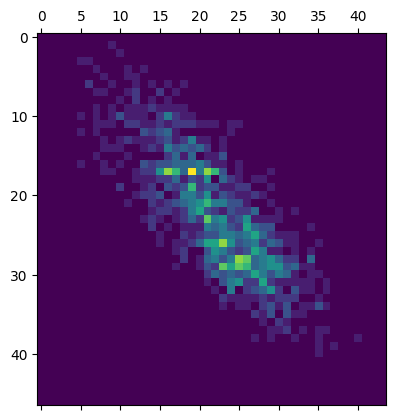

In [15]:
tok.eval()
tok.quantizer.clear_statistics()

test_ldr = DataLoader(dataset.test(), batch_size=10, shuffle=True)
for X,y in test_ldr:
  embeds = tok.encode(X)
  tokens = tok.quantize(embeds)

ks = sorted([k for k in tok.quantizer.statistics.keys()])
stat = [tok.quantizer.statistics[k] for k in ks]
print(max(stat))
print(np.mean(stat))
norm = np.sum(stat)

if tok.quantizer.dim == 1:
  plt.bar([k for k in ks], stat/norm)
else:
  kss = np.array(ks)
  _minx = int(min(kss[:,0]))
  _maxx = int(max(kss[:,0]))
  xrange = _maxx - _minx
  _miny = int(min(kss[:,1]))
  _maxy = int(max(kss[:,1]))
  yrange = _maxy - _miny
  mat = np.zeros((xrange, yrange))
  for k in ks:
    x,y = k
    x = int(x+abs(_minx)) - 1
    y = int(y+abs(_miny)) - 1
    mat[x,y] = tok.quantizer.statistics[k]/norm

  plt.matshow(mat)


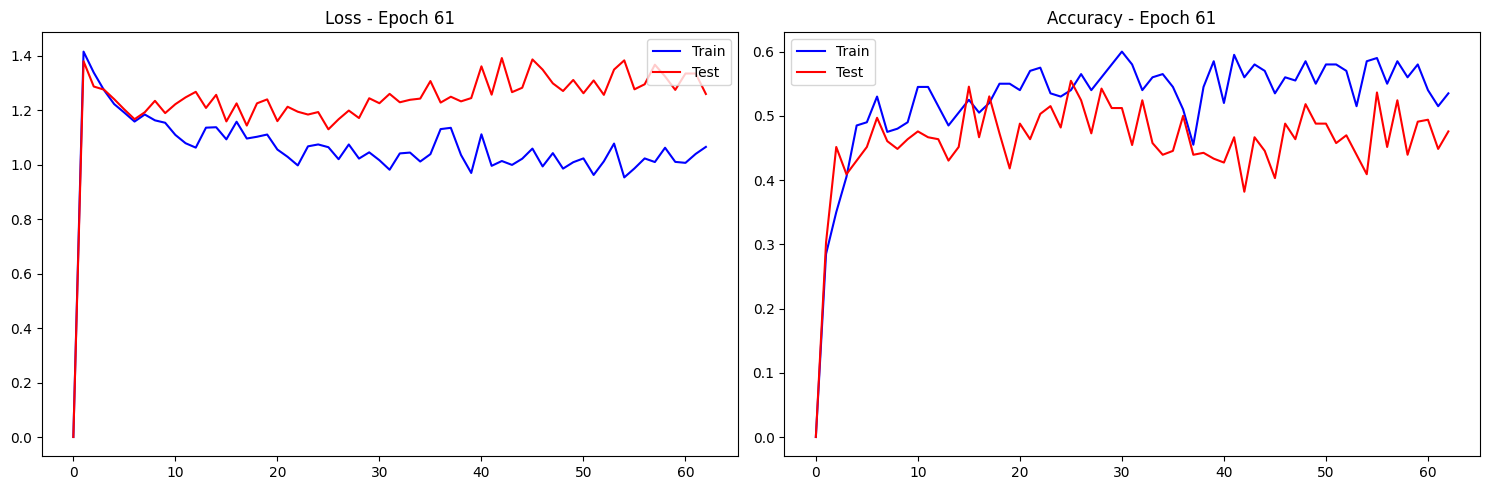

KeyboardInterrupt: 

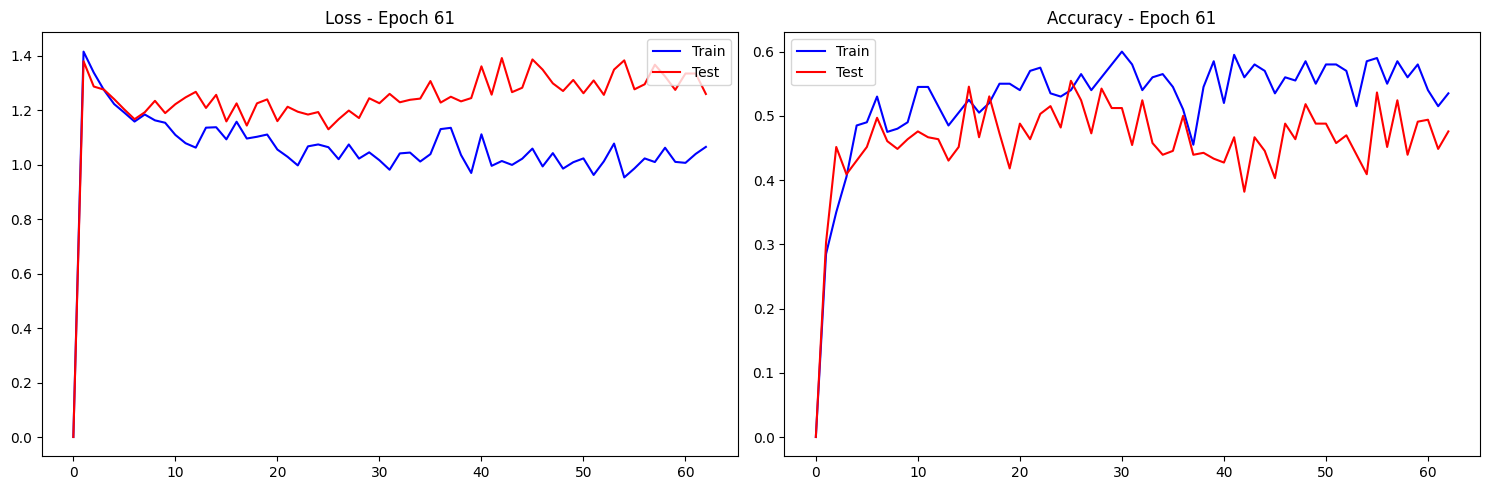

In [6]:
from clshq_tk.common import DEVICE
from clshq_tk.models.classifier import TSAttentionClassifier
from clshq_tk.training import classifier_training_loop

model = TSAttentionClassifier(tok, num_tokens=10, num_layers=1, num_heads=8, feed_forward = 512)

file = '{}-TSAttentionClassifier-LSH-Tokenizer-Triplet.pt'.format(name)


dataset.contrastive_type = None

classifier_training_loop(DEVICE, dataset, model, checkpoint_file = file,
                         epochs=200, lr = 0.01)

In [2]:
from clshq_tk.models.lsh_tokenizer import Tokenizer
from clshq_tk.common import DEVICE, DEFAULT_PATH
from clshq_tk.data import ClassificationTS, Noise, RandomTranslation

resume = True
name = 'RacketSports'
train = 200
string_labels = True
num_tokens = 50
embed_dim = 2
lags = 5
window_size = 10
step_size = 2
contrastive_type = None
file = '{}-tstokenizer-{}-lsh.pt'.format(name,contrastive_type, num_tokens)

dataset = ClassificationTS(name, train, contrastive_type, string_labels=string_labels, transforms=transforms.RandomChoice([
      Noise(type='unif', min=-.5, max=.5),
      RandomTranslation(max=1.)
  ]))

tok = Tokenizer(dataset.num_attributes, dataset.num_labels, embed_dim, 
                window_size, step_size, width= 50)

train_ldr = DataLoader(dataset.train(), batch_size=10, shuffle=True)

tok.train()
for X,y in train_ldr:
  embeds = tok(X)


fig, ax = plt.subplots(3, 1, figsize=(15, 10))

ks = sorted([k for k in tok.sample_level.statistics.keys()])
stat = [tok.sample_level.statistics[k] for k in ks]
ax[0].set_title("Max: {}   AVG: {}".format(max(stat),np.mean(stat)))
norm = np.sum(stat)

kss = np.array(ks)
_minx = int(min(kss[:,0]))
_maxx = int(max(kss[:,0]))
xrange = _maxx - _minx
_miny = int(min(kss[:,1]))
_maxy = int(max(kss[:,1]))
yrange = _maxy - _miny
mat = np.zeros((xrange, yrange))
for k in ks:
  x,y = k
  x = int(x+abs(_minx)) - 1
  y = int(y+abs(_miny)) - 1
  mat[x,y] = tok.sample_level.statistics[k]/norm

ax[0].matshow(mat)

ks = sorted([k for k in tok.patch_level.statistics.keys()])
stat = [tok.patch_level.statistics[k] for k in ks]
ax[1].set_title("Max: {}   AVG: {}".format(max(stat),np.mean(stat)))
norm = np.sum(stat)

kss = np.array(ks)
_minx = int(min(kss[:,0]))
_maxx = int(max(kss[:,0]))
xrange = _maxx - _minx
_miny = int(min(kss[:,1]))
_maxy = int(max(kss[:,1]))
yrange = _maxy - _miny
mat = np.zeros((xrange, yrange))
for k in ks:
  x,y = k
  x = int(x+abs(_minx)) - 1
  y = int(y+abs(_miny)) - 1
  mat[x,y] = tok.patch_level.statistics[k]/norm

ax[1].matshow(mat)


C:\Users\petronio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


1.0


RuntimeError: The expanded size of the tensor (2) must match the existing size (6) at non-singleton dimension 1.  Target sizes: [10, 2].  Tensor sizes: [10, 6]

1.0


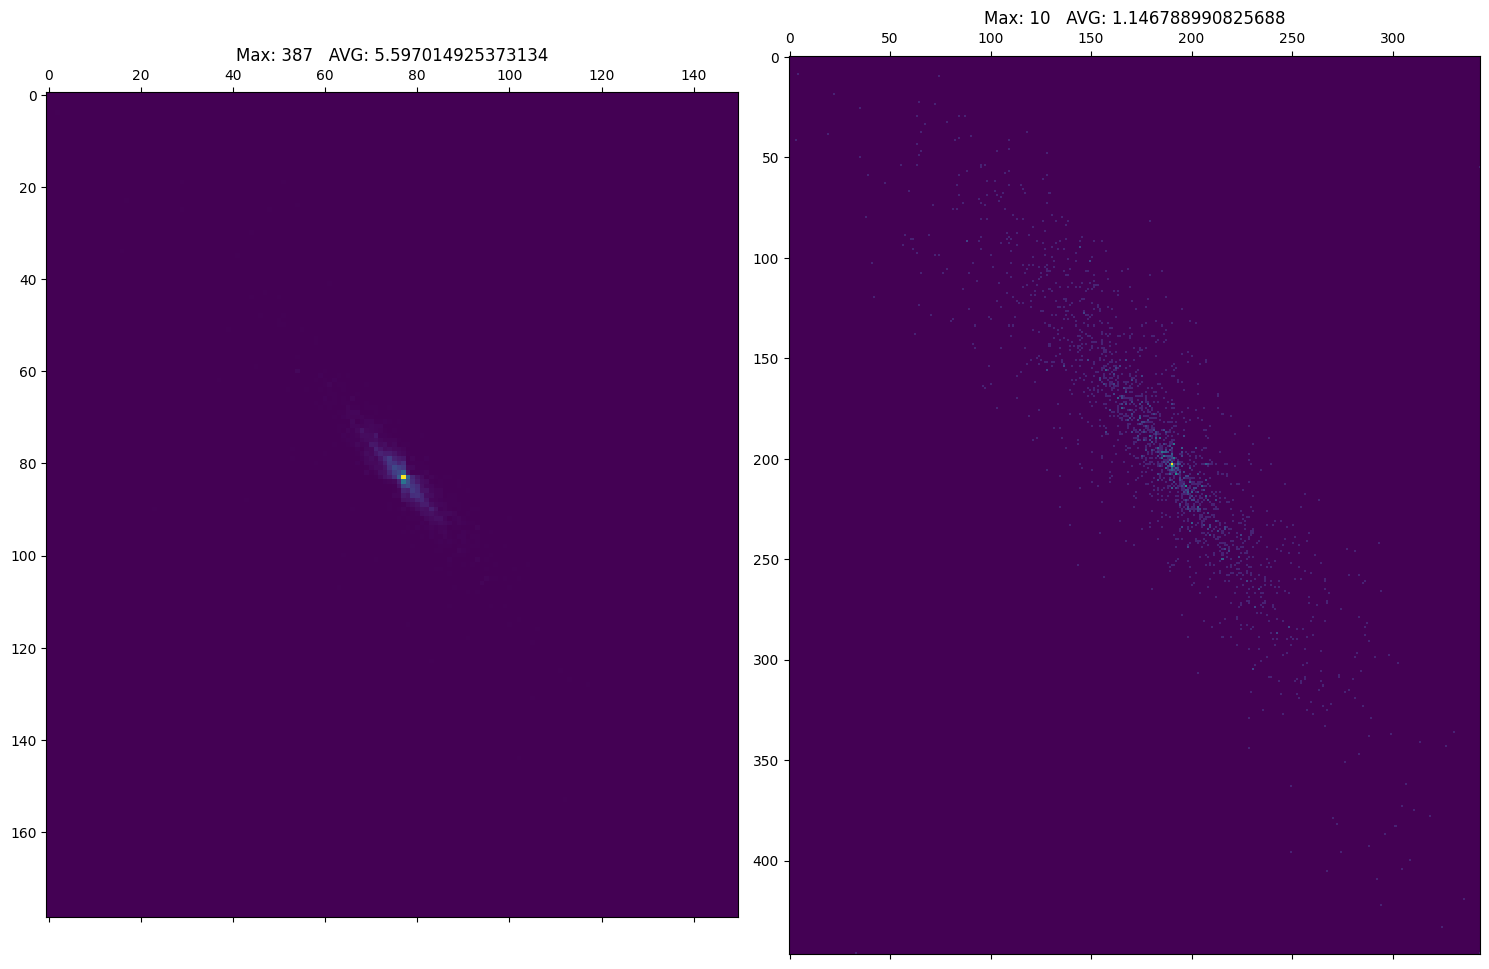

In [3]:
from clshq_tk.models.lsh_tokenizer import Tokenizer
from clshq_tk.common import DEVICE, DEFAULT_PATH
from clshq_tk.data import ClassificationTS, Noise, RandomTranslation

resume = True
name = 'RacketSports'
train = 200
string_labels = True
num_tokens = 50
embed_dim = 2
lags = 5
window_size = 10
step_size = 2
contrastive_type = None
file = '{}-tstokenizer-{}-lsh.pt'.format(name,contrastive_type, num_tokens)

dataset = ClassificationTS(name, train, contrastive_type, string_labels=string_labels, transforms=transforms.RandomChoice([
      Noise(type='unif', min=-.5, max=.5),
      RandomTranslation(max=1.)
  ]))

tok = Tokenizer(dataset.num_attributes, dataset.num_labels, embed_dim, 
                window_size, step_size, sample_width= 2, patch_width=1)

train_ldr = DataLoader(dataset.train(), batch_size=10, shuffle=True)

tok.train()
for X,y in train_ldr:
  embeds = tok(X)


fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ks = sorted([k for k in tok.sample_level.statistics.keys()])
stat = [tok.sample_level.statistics[k] for k in ks]
ax[0].set_title("Max: {}   AVG: {}".format(max(stat),np.mean(stat)))
norm = np.sum(stat)

kss = np.array(ks)
_minx = int(min(kss[:,0]))
_maxx = int(max(kss[:,0]))
xrange = _maxx - _minx
_miny = int(min(kss[:,1]))
_maxy = int(max(kss[:,1]))
yrange = _maxy - _miny
mat = np.zeros((xrange, yrange))
for k in ks:
  x,y = k
  x = int(x+abs(_minx)) - 1
  y = int(y+abs(_miny)) - 1
  mat[x,y] = tok.sample_level.statistics[k]/norm

ax[0].matshow(mat)

ks = sorted([k for k in tok.patch_level.statistics.keys()])
stat = [tok.patch_level.statistics[k] for k in ks]
ax[1].set_title("Max: {}   AVG: {}".format(max(stat),np.mean(stat)))
norm = np.sum(stat)

kss = np.array(ks)
_minx = int(min(kss[:,0]))
_maxx = int(max(kss[:,0]))
xrange = _maxx - _minx
_miny = int(min(kss[:,1]))
_maxy = int(max(kss[:,1]))
yrange = _maxy - _miny
mat = np.zeros((xrange, yrange))
for k in ks:
  x,y = k
  x = int(x+abs(_minx)) - 1
  y = int(y+abs(_miny)) - 1
  mat[x,y] = tok.patch_level.statistics[k]/norm

ax[1].matshow(mat)

plt.tight_layout()


RuntimeError: expected scalar type Double but found Float

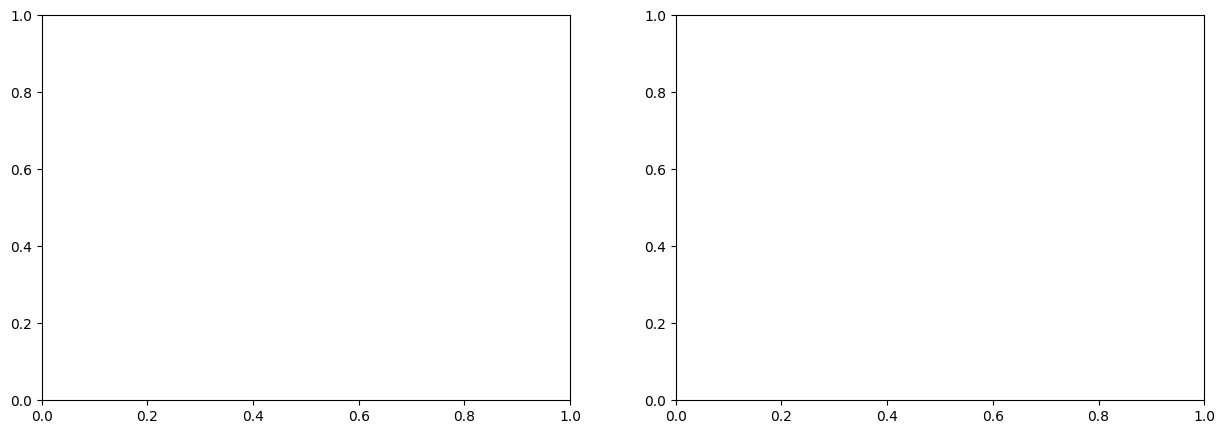

In [4]:
from clshq_tk.common import DEVICE
from clshq_tk.models.classifier import TSAttentionClassifier
from clshq_tk.training import classifier_training_loop

model = TSAttentionClassifier(tok, num_tokens=10, num_layers=1, num_heads=8, feed_forward = 512)

file = '{}-TSAttentionClassifier-LSH-Tokenizer-Triplet.pt'.format(name)


dataset.contrastive_type = None

classifier_training_loop(DEVICE, dataset, model, checkpoint_file = file,
                         epochs=200, lr = 0.01)